# Face Similarity Search

Import `mlmodule` modules

In [1]:
from mlmodule.torch.options import TorchRunnerOptions
from mlmodule.torch.runners import TorchInferenceRunner
from mlmodule.callbacks.memory import (
    CollectBoundingBoxesInMemory,
    CollectFeaturesInMemory,
)
from mlmodule.torch.datasets import (
    LocalBinaryFilesDataset,
    ImageDataset,
    ImageBoundingBoxDataset,
)
from mlmodule.helpers.files import list_files_in_dir

from mlmodule.models.mtcnn.pretrained import torch_mtcnn
from mlmodule.models.arcface.pretrained import torch_arcface_insightface

import torch
import matplotlib.pyplot as plt
import numpy as np
from facenet_pytorch.models.utils.detect_face import crop_resize
from PIL import Image
import seaborn as sns

sns.set(style="white")
%matplotlib inline

/home/lebret/projects/mlmodule/venv/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Load images

In [2]:
base_path = "../../tests/fixtures/berset"
file_names = list_files_in_dir(base_path, allowed_extensions=("jpg",))
# Load image dataset
berset_dataset = ImageDataset(LocalBinaryFilesDataset(file_names))

Run face detection with `torch_mtcnn`

In [3]:
torch_device = torch.device("cpu")
face_detector = torch_mtcnn(device=torch_device)

# Callbacks
bb = CollectBoundingBoxesInMemory()

# Runner
runner = TorchInferenceRunner(
    model=face_detector,
    dataset=berset_dataset,
    callbacks=[bb],
    options=TorchRunnerOptions(
        data_loader_options={"batch_size": 1}, device=torch_device, tqdm_enabled=True
    ),
)
runner.run()

100%|██████████| 3/3 [00:00<00:00,  7.45it/s]


Extract face features with `TorchArcFaceModule`

In [4]:
arcface = torch_arcface_insightface(device=torch_device)

# Dataset
dataset = ImageBoundingBoxDataset(
    image_dataset=ImageDataset(LocalBinaryFilesDataset(bb.indices)),
    bounding_boxes=bb.bounding_boxes,
)

# Callbacks
ff = CollectFeaturesInMemory()

# Runner
runner = TorchInferenceRunner(
    model=arcface,
    dataset=dataset,
    callbacks=[ff],
    options=TorchRunnerOptions(
        data_loader_options={"batch_size": 3}, device=torch_device, tqdm_enabled=True
    ),
)
runner.run()

100%|██████████| 4/4 [00:00<00:00,  4.02it/s]


Display the cropped faces

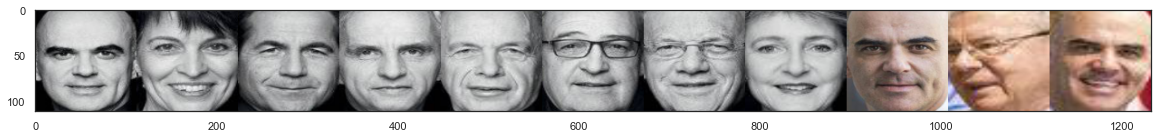

In [5]:
def image_grid(array, ncols=10):
    index, height, width, channels = array.shape
    nrows = index // ncols
    img_grid = (
        array.reshape(nrows, ncols, height, width, channels)
        .swapaxes(1, 2)
        .reshape(height * nrows, width * ncols, channels)
    )

    return img_grid


img_arr = []
for k, file_name in enumerate(bb.indices):
    img = Image.open(file_name).convert("RGB")
    bboxes = bb.bounding_boxes[k]
    for box in bboxes.bounding_boxes:
        cropped_face = np.asarray(crop_resize(img, box, image_size=112))
        img_arr.append(cropped_face)

result = image_grid(np.array(img_arr), ncols=len(img_arr))
fig = plt.figure(figsize=(20.0, 20.0))
plt.imshow(result)

Compute face similarity

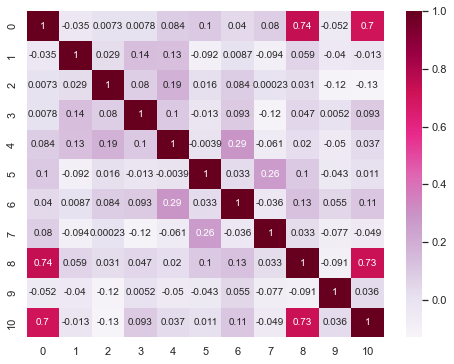

In [6]:
sim_mat = ff.features @ ff.features.T
fig, ax = plt.subplots(figsize=(8, 6))
ax = sns.heatmap(sim_mat, cmap="PuRd", annot=True)

From this heatmap, we can see that the cosine similarities between the three faces of Alain Berset is quite high (from 0.7 to 0.74) while they are very low between all other faces.